<a href="https://colab.research.google.com/github/yadavrishikesh/Deep-Learning-Slides-Code/blob/main/code/DL_OptimizationAlgorithm_Nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Algorithms on Non-Linearly Separable Data

In this notebook, we explore how linear logistic regression behaves on a non-linearly separable dataset.  
We use the same four optimizers: GD, SGD, Newton-Raphson, and Adam.  

We also visualize convergence and decision boundaries.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(42)


## 2. Generate Non-Linearly Separable Dataset (Circle-in-Circle)


In [13]:
def generate_circular_data(n_samples=200, radius_inner=1.0, radius_outer=2.5):
    """
    - Class 0: points inside a smaller circle
    - Class 1: points in a ring outside the inner circle
    """
    # Class 0 (inner circle)
    r0 = radius_inner * np.sqrt(np.random.rand(n_samples//2))
    theta0 = 2*np.pi*np.random.rand(n_samples//2)
    X0 = np.c_[r0*np.cos(theta0), r0*np.sin(theta0)]

    # Class 1 (outer ring)
    r1 = radius_inner + (radius_outer - radius_inner)*np.sqrt(np.random.rand(n_samples//2))
    theta1 = 2*np.pi*np.random.rand(n_samples//2)
    X1 = np.c_[r1*np.cos(theta1), r1*np.sin(theta1)]

    X = np.vstack([X0, X1])
    y = np.array([0]*(n_samples//2) + [1]*(n_samples//2))

    # Add bias term
    X = np.hstack([np.ones((n_samples,1)), X])

    return X, y.reshape(-1,1)

X, y = generate_circular_data()


### Visualize Non-Linear Dataset


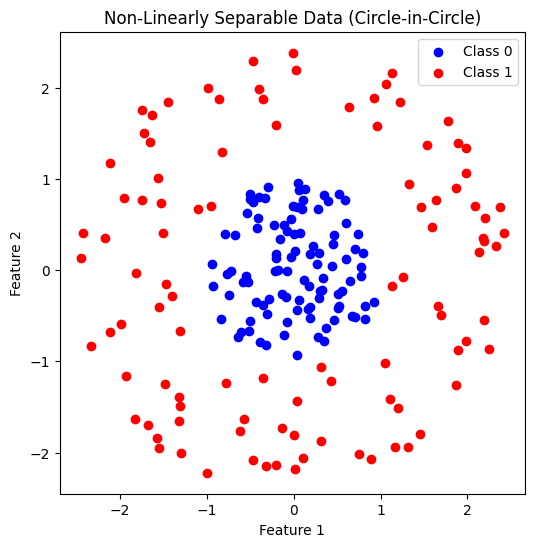

In [14]:
plt.figure(figsize=(6,6))
plt.scatter(X[y.flatten()==0,1], X[y.flatten()==0,2], color='blue', label='Class 0')
plt.scatter(X[y.flatten()==1,1], X[y.flatten()==1,2], color='red', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Non-Linearly Separable Data (Circle-in-Circle)')
plt.legend()
plt.show()


## 3. Logistic Regression: Sigmoid, Loss, Gradient, Hessian

In [15]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def binary_cross_entropy(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1-eps)
    return -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

def compute_gradient(X, y, w):
    y_pred = sigmoid(X @ w)
    return X.T @ (y_pred - y) / X.shape[0]

def compute_hessian(X, w):
    y_pred = sigmoid(X @ w)
    S = np.diag((y_pred*(1-y_pred)).flatten())
    return X.T @ S @ X / X.shape[0]


## 4. Optimization Algorithms from Scratch (GD, SGD, Newton-Raphson, Adam)


In [16]:
# 4.1 Gradient Descent
def gradient_descent(X, y, lr=0.1, epochs=100):
    w = np.zeros((X.shape[1],1))
    loss_history = []
    start_time = time.time()
    for i in range(epochs):
        grad = compute_gradient(X, y, w)
        w -= lr * grad
        loss_history.append(binary_cross_entropy(y, sigmoid(X @ w)))
    return w, loss_history, time.time()-start_time

# 4.2 Stochastic Gradient Descent
def stochastic_gradient_descent(X, y, lr=0.1, epochs=100):
    w = np.zeros((X.shape[1],1))
    loss_history = []
    n_samples = X.shape[0]
    start_time = time.time()
    for i in range(epochs):
        indices = np.random.permutation(n_samples)
        X_shuffled, y_shuffled = X[indices], y[indices]
        for j in range(n_samples):
            x_i = X_shuffled[j].reshape(1,-1)
            y_i = y_shuffled[j].reshape(-1,1)
            w -= lr * compute_gradient(x_i, y_i, w)
        loss_history.append(binary_cross_entropy(y, sigmoid(X @ w)))
    return w, loss_history, time.time()-start_time

# 4.3 Newton-Raphson
def newton_raphson(X, y, epochs=10):
    w = np.zeros((X.shape[1],1))
    loss_history = []
    start_time = time.time()
    for i in range(epochs):
        grad = compute_gradient(X, y, w)
        H = compute_hessian(X, w)
        try:
            w -= np.linalg.inv(H) @ grad
        except np.linalg.LinAlgError:
            w -= grad
        loss_history.append(binary_cross_entropy(y, sigmoid(X @ w)))
    return w, loss_history, time.time()-start_time

# 4.4 Adam Optimizer
def adam(X, y, lr=0.1, epochs=100, beta1=0.9, beta2=0.999, eps=1e-8):
    w = np.zeros((X.shape[1],1))
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    loss_history = []
    start_time = time.time()
    for t in range(1, epochs+1):
        grad = compute_gradient(X, y, w)
        m = beta1*m + (1-beta1)*grad
        v = beta2*v + (1-beta2)*(grad**2)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        w -= lr * m_hat / (np.sqrt(v_hat) + eps)
        loss_history.append(binary_cross_entropy(y, sigmoid(X @ w)))
    return w, loss_history, time.time()-start_time


## 5. Train All Optimizers and Record Execution Times


In [17]:
epochs = 50

w_gd, loss_gd, time_gd = gradient_descent(X, y, lr=0.1, epochs=epochs)
w_sgd, loss_sgd, time_sgd = stochastic_gradient_descent(X, y, lr=0.1, epochs=epochs)
w_nr, loss_nr, time_nr = newton_raphson(X, y, epochs=epochs)
w_adam, loss_adam, time_adam = adam(X, y, lr=0.1, epochs=epochs)

print("Execution Time (s):")
print("GD:", round(time_gd,4))
print("SGD:", round(time_sgd,4))
print("Newton-Raphson:", round(time_nr,4))
print("Adam:", round(time_adam,4))


Execution Time (s):
GD: 0.0059
SGD: 0.1707
Newton-Raphson: 0.01
Adam: 0.0038


## 6. Convergence Plot with Execution Times

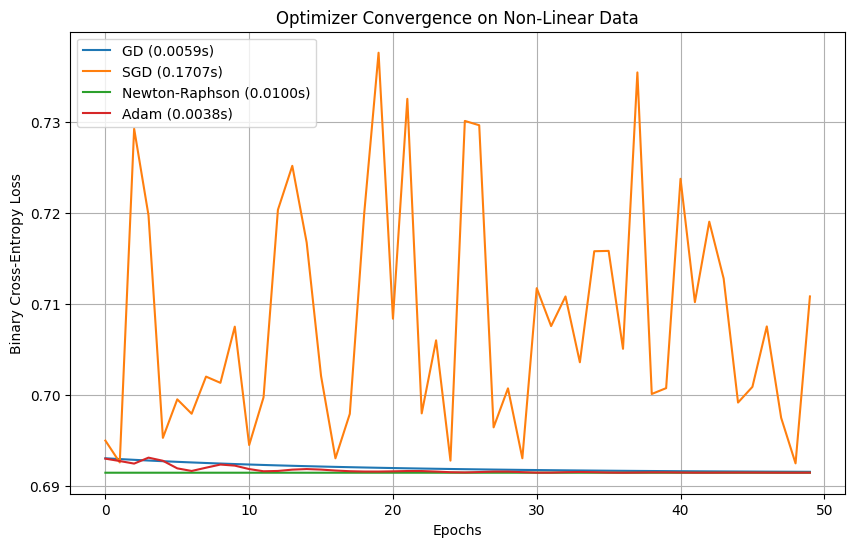

In [18]:
plt.figure(figsize=(10,6))
plt.plot(loss_gd, label=f'GD ({time_gd:.4f}s)')
plt.plot(loss_sgd, label=f'SGD ({time_sgd:.4f}s)')
plt.plot(loss_nr, label=f'Newton-Raphson ({time_nr:.4f}s)')
plt.plot(loss_adam, label=f'Adam ({time_adam:.4f}s)')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Optimizer Convergence on Non-Linear Data')
plt.legend()
plt.grid(True)
plt.show()


## 7. Decision Boundaries for All Optimizers in a Single Figure


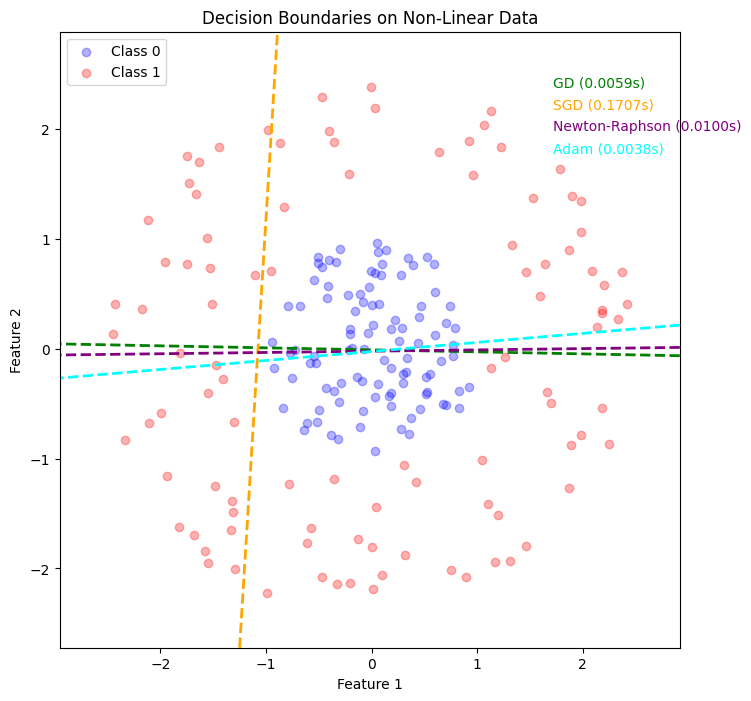

In [19]:
def plot_decision_boundary_multi(X, y, ws, labels, title='Decision Boundaries'):
    x_min, x_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    y_min, y_max = X[:,2].min()-0.5, X[:,2].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    plt.figure(figsize=(8,8))

    # Plot data
    plt.scatter(X[y.flatten()==0,1], X[y.flatten()==0,2], color='blue', label='Class 0', alpha=0.3)
    plt.scatter(X[y.flatten()==1,1], X[y.flatten()==1,2], color='red', label='Class 1', alpha=0.3)

    colors = ['green', 'orange', 'purple', 'cyan']

    for i, w in enumerate(ws):
        grid = np.c_[np.ones(xx.ravel().shape[0]), xx.ravel(), yy.ravel()]
        Z = sigmoid(grid @ w).reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=[0.5], colors=[colors[i]], linewidths=2, linestyles='--')
        plt.text(x_max-1.2, y_max-0.5-i*0.2, labels[i], color=colors[i])

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend()
    plt.show()

weights_list = [w_gd, w_sgd, w_nr, w_adam]
labels_list = [f'GD ({time_gd:.4f}s)', f'SGD ({time_sgd:.4f}s)', f'Newton-Raphson ({time_nr:.4f}s)', f'Adam ({time_adam:.4f}s)']

plot_decision_boundary_multi(X, y, weights_list, labels_list, title='Decision Boundaries on Non-Linear Data')
